# Social stat

## Cơ sở lý thuyết

Import các thư viện cần thiết

In [33]:
import copy
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels as stm
import torch 
import torch.nn as nn 
import torch.optim as optim
import tqdm

## Thống kê mô tả dữ liệu
<!-- Thống kê mô tả dữ liệu -->

## Tiền xử lý dữ liệu
<!-- Phát hiện outlier -->

Đọc dữ liệu

In [34]:
df = pyreadr.read_r('./data/gss16.rda')
gss16_data = df['gss16']
print(gss16_data.info())
print(gss16_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   harass5   1469 non-null   object 
 1   emailmin  1649 non-null   float64
 2   emailhr   1649 non-null   float64
 3   educ      2858 non-null   float64
 4   polviews  2756 non-null   object 
 5   advfront  1385 non-null   object 
 6   snapchat  1372 non-null   object 
 7   instagrm  1372 non-null   object 
 8   wrkstat   2864 non-null   object 
dtypes: float64(3), object(6)
memory usage: 201.7+ KB
None
  harass5  emailmin  emailhr  educ          polviews        advfront snapchat   
0     NaN       0.0     12.0  16.0          Moderate  Strongly agree      NaN  \
1     NaN      30.0      0.0  12.0           Liberal        Disagree       No   
2      No       NaN      NaN  16.0      Conservative             NaN       No   
3     NaN      10.0      0.0  12.0          Moderate        Disagree      NaN   
4

In [35]:
gss16_data.dropna(subset=['emailmin', 'emailhr'], inplace=True)
gss16_data['educ'].fillna(gss16_data['educ'].mean(), inplace = True)

col_num = ['emailmin', 'emailhr', 'educ']
col_cat = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']

df_cat = gss16_data[gss16_data.columns.intersection(col_cat)]
df_num = gss16_data[gss16_data.columns.intersection(col_num)]
df_cat_fill = df_cat.fillna('unknown')

print(f'cat na: {df_cat.isna().sum()}')
print(f'cat fill na: {df_cat_fill.isna().sum()}')

print(df_cat.info())
print(df_num.info())

cat na: harass5     1218
polviews      55
advfront     433
snapchat     969
instagrm     969
wrkstat        1
dtype: int64
cat fill na: harass5     0
polviews    0
advfront    0
snapchat    0
instagrm    0
wrkstat     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2865
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   harass5   431 non-null    object
 1   polviews  1594 non-null   object
 2   advfront  1216 non-null   object
 3   snapchat  680 non-null    object
 4   instagrm  680 non-null    object
 5   wrkstat   1648 non-null   object
dtypes: object(6)
memory usage: 90.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1649 entries, 0 to 2865
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   emailmin  1649 non-null   float64
 1   emailhr   1649 non-null   float64
 2   educ      1649 non-null   float64
dtypes: float64(3)
m

In [36]:
df_num['email_time'] = df_num['emailhr'] * 60 + df_num['emailmin']

max_email_time = df_num['email_time'].max()
min_email_time = df_num['email_time'].min()
df_num['email_time_center'] = (df_num['email_time'] - min_email_time) / (max_email_time - min_email_time)

/tmp/ipykernel_65744/711746736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['email_time'] = df_num['emailhr'] * 60 + df_num['emailmin']
/tmp/ipykernel_65744/711746736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['email_time_center'] = (df_num['email_time'] - min_email_time) / (max_email_time - min_email_time)


In [37]:
max_educ = df_num['educ'].max()
min_educ = df_num['educ'].min()
df_num['educ_center'] = (df_num['educ'] - min_educ) / (max_educ - min_educ)

/tmp/ipykernel_65744/3923756970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['educ_center'] = (df_num['educ'] - min_educ) / (max_educ - min_educ)


Ghi các tập dữ liệu đã tiền xử lý ra file. Trong đó X, X_fill và y lần lượt là tập đầu vào không coi NaN là một thuộc tính, tập đầu vào coi NaN là thuộc tính ("unlnown"), tập đầu ra

In [38]:
df_cat_dum = pd.get_dummies(df_cat, dtype=int)
df_cat_fill_dum = pd.get_dummies(df_cat_fill, dtype=int)

df_num.to_csv('./data/preprocessing/gss16_number_columns', index=False)
df_cat_dum.to_csv('./data/preprocessing/gss16_dummies_column', index=False)
df_cat_fill_dum.to_csv('./data/preprocessing/gss16_dummies_column_fillna', index=False)

X = pd.concat([df_num['educ_center'], df_cat_dum], axis=1)
X_fill = pd.concat([df_num['educ_center'], df_cat_fill_dum], axis=1)
y = df_num['email_time_center']

X.to_csv('./data/preprocessing/X.csv', index=False)
X_fill.to_csv('./data/preprocessing/X_fill.csv', index=False)
y.to_csv('./data/preprocessing/y.csv', index=False)

Chia tập train, test với tỉ lệ 80/20, cố định `random_state = 42`

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_fill, y, test_size=0.2, random_state=42)

## Các mô hình tuyến tính

### Mô hình GLM 

### Mô hình GAM

### Mô hình GLM với penalty

### Mô hình GLM với Bayes

### Mô hình Random forest

### Mô hình Deep Learning 
Phần này sử dụng một mạng neural network đơn giản để fit mô hình. 

In [40]:
torch.cuda.is_available()

True

Định nghĩa mô hình và thuật toán tối ưu. 
Mạng gồm 2 hidden layers.
Loss function sử dụng là hàm Mean Square Error.
Thuật toán tối ưu là thuật toán Adam với learning rate 0.0001

In [41]:
model = nn.Sequential(
  nn.Linear(34, 64),
  nn.ReLU(),
  nn.Linear(64, 32),
  nn.Sigmoid(),
  nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Đưa dữ liệu vào vRAM của GPU

In [42]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

Các tham số cơ bản

In [43]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
early_stopping_epoches = 10

Huấn luyện mô hình

In [44]:
# training loop
early = 0
for epoch in range(n_epochs):
    print(f'process epoch: {epoch}')
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    print(f'complete epoch {epoch} with mse {mse}')
    if mse > best_mse:
        early += 1
        if early > early_stopping_epoches:
            print(f'early stopping')
            break
    
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

process epoch: 0
complete epoch 0 with mse 0.014326960779726505
process epoch: 1
complete epoch 1 with mse 0.014125876128673553
process epoch: 2
complete epoch 2 with mse 0.013956520706415176
process epoch: 3
complete epoch 3 with mse 0.013820012100040913
process epoch: 4
complete epoch 4 with mse 0.013713710941374302
process epoch: 5
complete epoch 5 with mse 0.013633067719638348
process epoch: 6
complete epoch 6 with mse 0.01357328798621893
process epoch: 7
complete epoch 7 with mse 0.013529235497117043
process epoch: 8
complete epoch 8 with mse 0.013493734411895275
process epoch: 9
complete epoch 9 with mse 0.013466090895235538
process epoch: 10
complete epoch 10 with mse 0.013443461619317532
process epoch: 11
complete epoch 11 with mse 0.013423372060060501
process epoch: 12
complete epoch 12 with mse 0.013405011035501957
process epoch: 13
complete epoch 13 with mse 0.013388932682573795
process epoch: 14
complete epoch 14 with mse 0.013374043628573418
process epoch: 15
complete epoc

Vẽ đồ thị loss function theo epoch

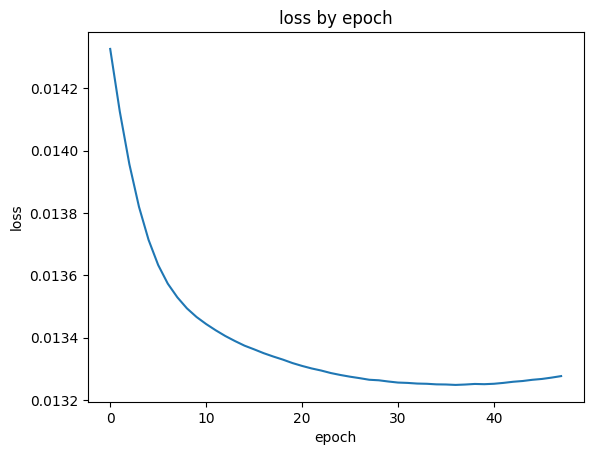

In [45]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.plot(history)
plt.show()

In ra các độ đo

In [46]:
y_pred = model(X_test)
y_pred_df = pd.DataFrame(y_pred.detach().numpy())
y_test_df = pd.DataFrame(y_test.detach().numpy())

mse = mean_squared_error(y_test_df, y_pred_df)
r2 = r2_score(y_test_df, y_pred_df)

print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'R2: {r2}')

MSE: 0.013247950933873653
RMSE: 0.11509974300861359
R2: 0.07854985973329653
